In [1]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
rdkit is already installed


In [2]:
!pip install plotly --upgrade

     |████████████████████████████████| 12.9MB 243kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


#Kindly Run this Notebook On Google Colab to install Rdkit and to view interactive plotly plots. Do not open it in Jupyter Notebook.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import rdkit
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import ColorConverter
from skimage import data
from skimage.color import rgb2gray
import numpy
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ColorConverter
from skimage import data
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,MaxPool2D,Conv2D,Flatten
from keras import optimizers
from keras.layers import Dropout
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem import Descriptors 
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw



## Reading and Cleaning Dataset

In [4]:
df=pd.read_csv("molecules.csv",encoding= 'unicode_escape')
df=df.dropna(how="all")
df=df.iloc[:,:3]
df["Nomenclature Name"]=df.iloc[:,2]
df["Molecular Structure"]=df.iloc[:,1]
df["Tg"]=df.iloc[:,0]
df=df[["Nomenclature Name","Molecular Structure","Tg"]]
df.head(5)

Nomenclature Name          Molecular Structure     Tg
0         Poly(4-biphenyl acrylate)  C=CC(=O)Oc2ccc(c1ccccc1)cc2  383.0
1              Poly(butyl acrylate)                CCCCOC(=O)C=C  219.0
2          Poly(sec-butyl acrylate)              CC(OC(=O)C=C)CC  250.0
3  Poly(2-tertbutylphenyl acrylate)    C=CC(=O)Oc1ccccc1C(C)(C)C  345.0
4  Poly(4-tertbutylphenyl acrylate)  C=CC(=O)Oc1ccc(C(C)(C)C)cc1  344.0

##Exploratory Data Analysis
### Classifying Polymers

In [8]:
def assign_groups(x):
  if'acrylate'in x:
    return 'Acrylates'
  if'styrene' in x:
    return 'Styrenes'
  if 'amide' in x:
    return 'Amides' 
  if 'ether' in x:
    return 'Ether'
  if 'carbonate' in x:
    return 'Carbonates'
  else:
    return 'Others' 
df["Class_of_Polymer"]=df["Nomenclature Name"].apply(assign_groups)
df["Class_of_Polymer"].value_counts()

Acrylates     149
Others        101
Styrenes       69
Amides         15
Ether           9
Carbonates      8
Name: Class_of_Polymer, dtype: int64

In [14]:
labels=df.Class_of_Polymer.unique()
count=df.Class_of_Polymer.value_counts().tolist()
labels = labels
values = count

colors = ['gold', 'mediumturquoise', 'darkorange']

fig = go.Figure(data=[go.Pie(labels=labels, values=values,pull=[0,0,0.1])])

fig.update_layout( font=dict(
        family="arial",
        size=24,
        
))


fig.show()


In [10]:
fig = px.box(df, y="Tg",color="Class_of_Polymer",)
fig.update_layout(
    
    yaxis_title="Tg",
    
    xaxis_title="Class of Polymer",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    
    
    
    font=dict(
        family="arial",
        size=22,
        color="black"
    )
    )

fig.update_traces(boxpoints='all', jitter=0)
fig.update_layout(showlegend=True)


     
fig.show()


### Distribution of Charge in Monomer

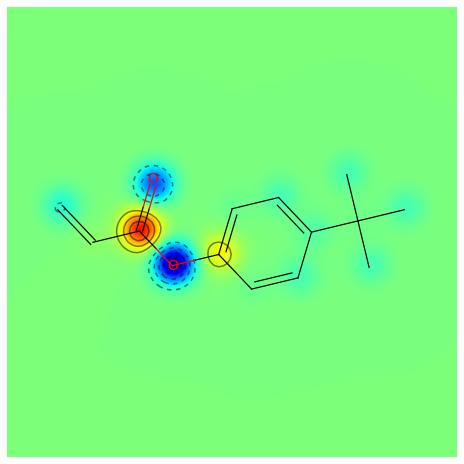

In [30]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('C=CC(=O)Oc1ccc(C(C)(C)C)cc1	')
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
AllChem.ComputeGasteigerCharges(mol)



## Visualization of Functional Groups

In [17]:
mol = Chem.MolFromSmiles('CC(OC(=O)C=C)CC')
image=rdkit.Chem.Draw.MolToImage(mol, highlightAtoms=[1,2], highlightColor=ColorConverter().to_rgb("gray"))
image

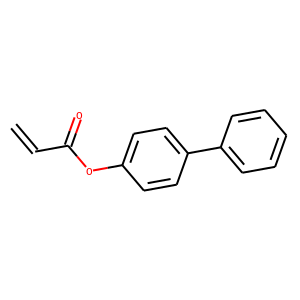

In [20]:
mol=Chem.MolFromSmiles("C=CC(=O)Oc2ccc(c1ccccc1)cc2")
rdkit.Chem.Draw.MolToImage(mol)

##Model 1

##Encoding SMILES TO Image

In [22]:
def encoding(df):
  encoded=[]
  elements=[['c'], ['n'], ['o'], ['C'], ['N'], ['F'], ['='], ['O'], 
            ['('], [')'], ['1'],['2'],['#'],['Cl'],['/'],['S'],['Br']]
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(elements)
  enc.categories_
  df1=df["Molecular Structure"].apply(lambda x: pd.Series(list(x)))
  for i in range(df1.shape[0]):
    x=enc.transform(pd.DataFrame(df1.iloc[i,:]).dropna(how="all").values).toarray()
    y=np.zeros(((df1.shape[1]-x.shape[0]),len(elements)))
    encoded.append(np.vstack((x,y)))
  return encoded

def encoded_generate_images(df):
  listt=encoding(df)
  plt.figure(figsize=(20,100))
  for i in range(len(listt)):
    plt.subplot(len(listt),5,i+1)
    plt.imshow(listt[i])

Nomenclature Name  ... Class_of_Polymer
0         Poly(4-biphenyl acrylate)  ...        Acrylates
1              Poly(butyl acrylate)  ...        Acrylates
2          Poly(sec-butyl acrylate)  ...        Acrylates
3  Poly(2-tertbutylphenyl acrylate)  ...        Acrylates
4  Poly(4-tertbutylphenyl acrylate)  ...        Acrylates

[5 rows x 4 columns]

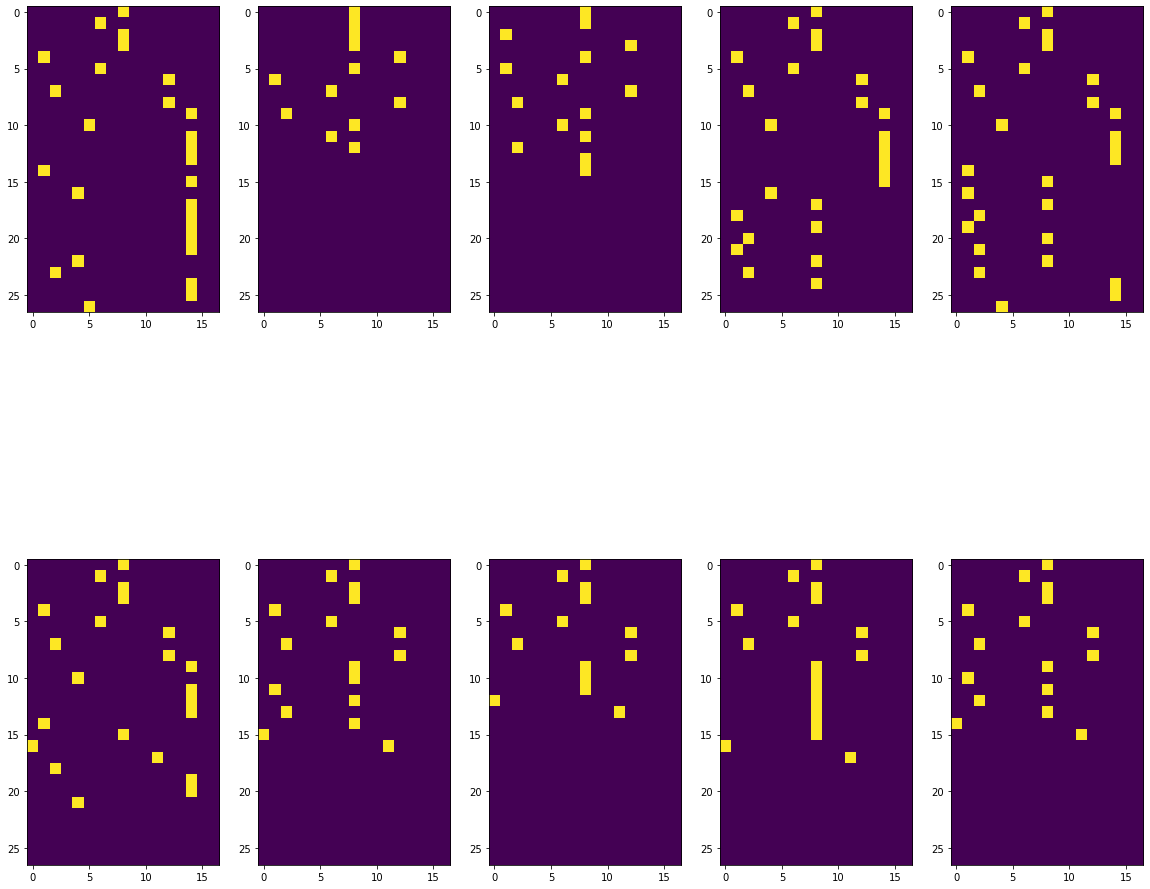

In [23]:
encoded_generate_images(df.head(10))
df.head(5)

## CNN

In [26]:
X=encoding(df)
X=np.array(X)
X=X.reshape(351,65,17,1)
X.shape
Y=df["Tg"].values

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
from keras import optimizers
model=Sequential()
model.add(Conv2D(64,(5,5), activation="relu",kernel_regularizer="l2",input_shape=(65,17,1)))
model.add(Conv2D(32,(3,3),kernel_regularizer="l2", activation="relu"))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(32,activation="relu",kernel_regularizer="l2"))
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Dense(1))
optimizer=optimizers.adam(lr=0.03)
  
model.compile(optimizer=optimizer,loss="mean_absolute_error",)
Model_rms_1=model.fit(x=X_train,y=y_train,epochs=180,batch_size=64,validation_split=0.1)


Train on 268 samples, validate on 30 samples
Epoch 1/180
268/268 [==============================] - 7s 27ms/step - loss: 190.0326 - val_loss: 88.4462
Epoch 2/180
268/268 [==============================] - 0s 142us/step - loss: 99.7326 - val_loss: 65.0228
Epoch 3/180
268/268 [==============================] - 0s 140us/step - loss: 113.4739 - val_loss: 68.4141
Epoch 4/180
268/268 [==============================] - 0s 133us/step - loss: 89.1268 - val_loss: 76.0173
Epoch 5/180
268/268 [==============================] - 0s 124us/step - loss: 73.9198 - val_loss: 74.1447
Epoch 6/180
268/268 [==============================] - 0s 125us/step - loss: 63.8840 - val_loss: 61.4686
Epoch 7/180
268/268 [==============================] - 0s 129us/step - loss: 61.8159 - val_loss: 59.0344
Epoch 8/180
268/268 [==============================] - 0s 141us/step - loss: 65.5265 - val_loss: 53.8797
Epoch 9/180
268/268 [==============================] - 0s 123us/step - loss: 60.2242 - val_loss: 56.8902
Epoch 10/

In [28]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
MAE_test=abs(y_predtest.reshape(y_test.shape)-y_test).sum()/y_test.shape
MAE_train=abs(y_predtrain.reshape(y_train.shape)-y_train).sum()/y_train.shape
print("Mean Absolute Error on Training Set = ",MAE_train.item())
print("Mean Absolute Error on Test Set = ",MAE_test.item())

Mean Absolute Error on Training Set =  17.835301034402526
Mean Absolute Error on Test Set =  21.84800864165684


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_predtest.reshape(y_test.shape), y=y_test.reshape(y_test.shape),
    name='sin',
    mode='markers',
    marker_color='rgba(100, 10, 90, .8)'))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=13)
fig.update_layout(
    
    yaxis_title="Exprimental Tg",
    xaxis_title="Predicted Tg",
    title="Test Set",
    
    font=dict(
        family="arial",
        size=24,
        color="black"
    )
    )
                  
fig.show()


In [36]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_predtrain.reshape(y_train.shape), y=y_train.reshape(y_train.shape),
    name='sin',
    mode='markers',
    marker_color='rgba(100, 10, 90, .8)'))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=13)
fig.update_layout(
    
    yaxis_title="Exprimental Tg",
    xaxis_title="Predicted Tg",
    title="Train Set",
    
    font=dict(
        family="arial",
        size=24,
        color="black"
    )
    )
                  
fig.show()


In [37]:
y_p=y_predtrain.reshape(y_train.shape)
y_a=y_train.reshape(y_train.shape)
print("Relative Train Error in % = ",(((abs(y_p-y_a)/y_a)*100).sum())/y_train.shape)


Relative Train Error in % =  [6.04230179]


In [38]:
y_p=y_predtest.reshape(y_test.shape)
y_a=y_test.reshape(y_test.shape)
print("AVG % Unseen Test Error=",(((abs(y_p-y_a)/y_a)*100).sum())/y_test.shape)

AVG % Unseen Test Error= [7.13429228]


In [40]:




fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(1,201), y=Model_rms_1.history["loss"],
    name='sin',
    mode='markers',
    marker_color='rgba(100, 10, 90, .8)'))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=13)
fig.update_layout(
    
    yaxis_title="Train Error",
    xaxis_title="Number of Epochs",
    
    font=dict(
        family="arial",
        size=24,
        color="black"
    )
    )
                  
fig.show()


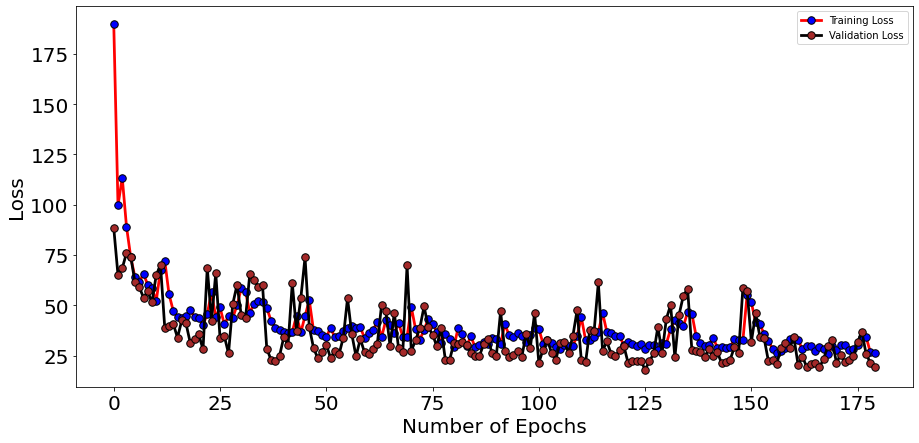

In [41]:
plt.figure(figsize=(15,7))
plt.plot(Model_rms_1.history["loss"],color='r', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='b',
         markeredgecolor='black',
         markeredgewidth=1,label="Training Loss")
plt.plot(Model_rms_1.history['val_loss'],color='black', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='brown',
         markeredgecolor='black',
         markeredgewidth=1,label="Validation Loss")
plt.xlabel("Number of Epochs",size=20,color="black")
plt.ylabel("Loss",size=20,color="black")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend()


plt.show()

##Model 2-ANN

### Neural Network using Bond Features

In [42]:
mw={"C":12,"c":12,"O":16,"o":16,"N":14,"F":19}
def Molecular_Weight(text):
  Mass=[]
  for elements in text:
    if elements=="C":
      Mass.append(mw[elements])
    elif elements=="c":
      Mass.append(mw[elements])
    elif elements=="o":
      Mass.append(mw[elements])
    elif elements=="O":
      Mass.append(mw[elements])
    elif elements=="F":
      Mass.append(mw[elements])
    elif elements=="N":
      Mass.append(mw[elements])  
  return sum(Mass)




In [43]:
df.head()

Nomenclature Name  ... Class_of_Polymer
0         Poly(4-biphenyl acrylate)  ...        Acrylates
1              Poly(butyl acrylate)  ...        Acrylates
2          Poly(sec-butyl acrylate)  ...        Acrylates
3  Poly(2-tertbutylphenyl acrylate)  ...        Acrylates
4  Poly(4-tertbutylphenyl acrylate)  ...        Acrylates

[5 rows x 4 columns]

### Feature Engineering

In [44]:
df["C_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c'))
df["C_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('C'))
df["O_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('O'))
df["O_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('o'))
df["N_Double Bonds_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c')/2)
df["N_Double Bonds_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('='))
df["Nitrogen_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('N'))
df["F_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('F'))
df["MW"]=df["Molecular Structure"].apply(lambda x: Molecular_Weight(x))
df["Total Number of Atoms"]=df["Molecular Structure"].apply(lambda x: len(x))
df["Number of Double Bonds"]=df["Molecular Structure"].apply(lambda x:len(x)-x.count('=')-1)
df["Number of Triple Bonds"]=df["Molecular Structure"].apply(lambda x: x.count("#"))
df["Branching"]=df["Molecular Structure"].apply(lambda x: (x.count("(")+x.count(")"))/2)
df["Chlorine_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('Cl'))
df["Bromine_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('Br'))
df["Sulphur_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('S'))
df["Two_Structures"]=df["Molecular Structure"].apply(lambda x: x.count('.'))
df["If_Aromatic"]=df["Molecular Structure"].apply(lambda x: 1 if 'c' in x else 0)
df["No_of_Branched_C"]=df["Molecular Structure"].apply(lambda x: x.count('(C)'))
df["No_of_Branched_F"]=df["Molecular Structure"].apply(lambda x: x.count('(F)'))
df["No_of_Branched_Cl"]=df["Molecular Structure"].apply(lambda x: x.count('(Cl)'))
df["No_of_Branched_Br"]=df["Molecular Structure"].apply(lambda x: x.count('(Br)'))
df["No_of_Branched_=O"]=df["Molecular Structure"].apply(lambda x: x.count('(=O)'))
df["Number_of_C=C"]=df["Molecular Structure"].apply(lambda x: x.count('C=C')+x.count('cc'))
df["Number_of_C-C"]=df["Molecular Structure"].apply(lambda x: x.count('CC'))
df["Benze_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c1ccccc1'))
df["Benze_Ring_var"]=df["Molecular Structure"].apply(lambda x: x.count('c1cc'))
df["Benze_Ring_varr"]=df["Molecular Structure"].apply(lambda x: x.count('cc1'))

In [45]:
df.head()

Nomenclature Name  ... Benze_Ring_varr
0         Poly(4-biphenyl acrylate)  ...               1
1              Poly(butyl acrylate)  ...               0
2          Poly(sec-butyl acrylate)  ...               0
3  Poly(2-tertbutylphenyl acrylate)  ...               1
4  Poly(4-tertbutylphenyl acrylate)  ...               1

[5 rows x 32 columns]

## Standardization of Features

In [47]:
X=df.iloc[:,4:]
Y=df[["Tg"]]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1],activation="relu",kernel_regularizer="l2"))
model.add(Dense(10,activation="relu",kernel_regularizer="l2"))
model.add(Dense(30,activation="relu",kernel_regularizer="l2"))
model.add(Dense(1))
optimizer=optimizers.adam(lr=0.05)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=180,batch_size=100,validation_split=0.1)
  

Train on 268 samples, validate on 30 samples
Epoch 1/180
268/268 [==============================] - 0s 481us/step - loss: 296.2275 - val_loss: 293.5745
Epoch 2/180
268/268 [==============================] - 0s 59us/step - loss: 269.1513 - val_loss: 203.7186
Epoch 3/180
268/268 [==============================] - 0s 49us/step - loss: 155.9054 - val_loss: 148.2025
Epoch 4/180
268/268 [==============================] - 0s 58us/step - loss: 139.5052 - val_loss: 73.2993
Epoch 5/180
268/268 [==============================] - 0s 55us/step - loss: 81.2411 - val_loss: 90.0520
Epoch 6/180
268/268 [==============================] - 0s 56us/step - loss: 76.7682 - val_loss: 69.8362
Epoch 7/180
268/268 [==============================] - 0s 54us/step - loss: 65.9488 - val_loss: 50.5803
Epoch 8/180
268/268 [==============================] - 0s 63us/step - loss: 55.6977 - val_loss: 52.9961
Epoch 9/180
268/268 [==============================] - 0s 78us/step - loss: 50.0830 - val_loss: 49.6090
Epoch 10/18

In [65]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
y_p=y_predtrain.reshape(y_train.shape)
y_a=y_train.values.reshape(y_train.shape)
print("Relative Train Error in % = ",(((abs(y_p-y_a)/y_a)*100).sum())/y_train.shape)
y_p=y_predtest.reshape(y_test.shape)
y_a=y_test.values.reshape(y_test.shape)
print("AVG % Unseen Test Error=",(((abs(y_p-y_a)/y_a)*100).sum())/y_test.shape)

Relative Train Error in % =  [   5.33321362 1589.29765929]
AVG % Unseen Test Error= [  5.94695541 315.18863675]


In [66]:
fig = go.Figure(data=go.Scattergl(
    x = y_predtrain.reshape(y_train.shape[0]),
    y = y_train.values.reshape(y_train.shape[0]),
    mode='markers',
    marker=dict(
        color=np.random.randn(y_train.shape[0]),
        colorscale='Viridis',
        line_width=2
    )))


fig.update_traces(mode='markers', marker_line_width=2, marker_size=13)
fig.update_layout(
    
    yaxis_title="Experimental Tg",
    xaxis_title="Predicted Tg",
    
    font=dict(
        family="arial",
        size=24,
        color="black"
    )
    )

fig.show()









In [67]:

fig = go.Figure(data=go.Scattergl(
    x = y_predtest.reshape(y_test.shape[0]),
    y = y_test.values.reshape(y_test.shape[0]),
    mode='markers',
    marker=dict(
        color=np.random.randn(y_test.shape[0]),
        colorscale='Viridis',
        line_width=2
    )))


fig.update_traces(mode='markers', marker_line_width=2, marker_size=13)
fig.update_layout(
    
    yaxis_title="Experimental Tg",
    xaxis_title="Predicted Tg",
    
    font=dict(
        family="arial",
        size=24,
        color="black"
    )
    )

fig.show()









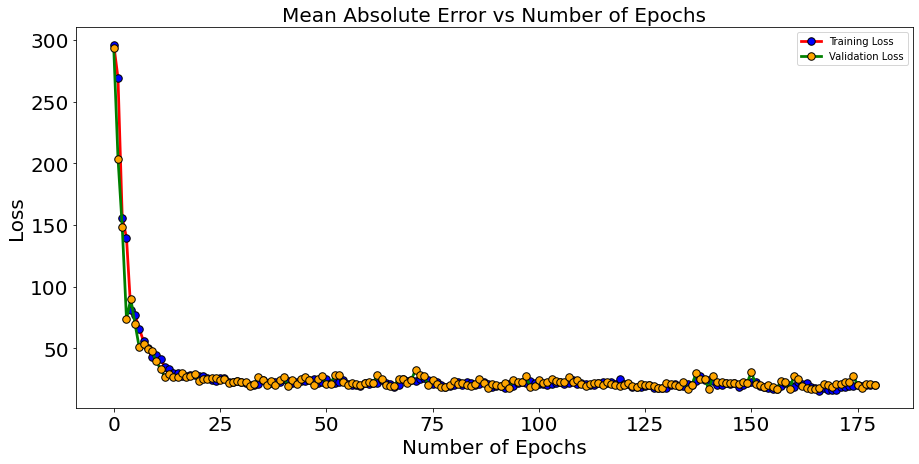

In [68]:
plt.figure(figsize=(15,7))
plt.plot(Model.history["loss"],color='r', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='b',
         markeredgecolor='black',
         markeredgewidth=1,label="Training Loss")
plt.plot(Model.history['val_loss'],color='green', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='orange',
         markeredgecolor='black',
         markeredgewidth=1,label="Validation Loss")
plt.xlabel("Number of Epochs",size=20,color="black")
plt.ylabel("Loss",size=20,color="black")

plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Mean Absolute Error vs Number of Epochs",size=20)
plt.legend()
plt.show()

In [69]:
y_p=y_predtrain.reshape(y_train.shape)
y_a=y_train.values.reshape(y_train.shape)
print("Relative Train Error in % = ",(((abs(y_p-y_a)/y_a)*100).sum())/y_train.shape)


Relative Train Error in % =  [   5.33321362 1589.29765929]


In [70]:
y_p=y_predtest.reshape(y_test.shape)
y_a=y_test.values.reshape(y_test.shape)
print("AVG % Unseen Test Error=",(((abs(y_p-y_a)/y_a)*100).sum())/y_test.shape)

AVG % Unseen Test Error= [  5.94695541 315.18863675]


### Future Work
#### Chemical Fingerprints Approach 


In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [ ]:
df

Nomenclature Name  ... Branching
0           Poly(4-biphenyl acrylate)  ...         4
1                Poly(butyl acrylate)  ...         2
2            Poly(sec-butyl acrylate)  ...         4
3    Poly(2-tertbutylphenyl acrylate)  ...         6
4    Poly(4-tertbutylphenyl acrylate)  ...         8
..                                ...  ...       ...
296          Poly(dodecano-12-lactam)  ...         2
297            Poly(decano-10-lactam)  ...         2
298             Poly(octano-8-lactam)  ...         0
299        Poly(6-aminohexanoic acid)  ...         0
300            Poly(propano-3-lactam)  ...         0

[277 rows x 16 columns]

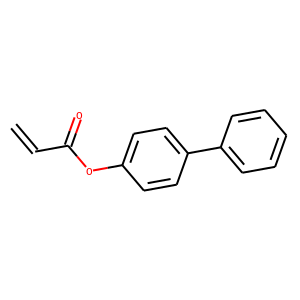

In [ ]:

mol=Chem.MolFromSmiles("C=CC(=O)Oc2ccc(c1ccccc1)cc2")
mol2=Chem.MolFromSmiles("C=CC(=O)Oc1ccc(C(C)(C)C)cc1")
Descriptors.MolWt(mol)
rdkit.Chem.Draw.MolToImage(mol)

In [ ]:
bi={}
fp=AllChem.GetMorganFingerprintAsBitVect(mol,6,2056,bitInfo=bi)
fp_array=np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp,fp_array)
np.nonzero(fp_array)

(array([   9,   75,  155,  343,  606,  752,  765,  869,  903,  941,  971,
        1022, 1071, 1098, 1102, 1162, 1510, 1574, 1583, 1653, 1703, 1710,
        1841, 1869, 2000, 2004, 2034]),)

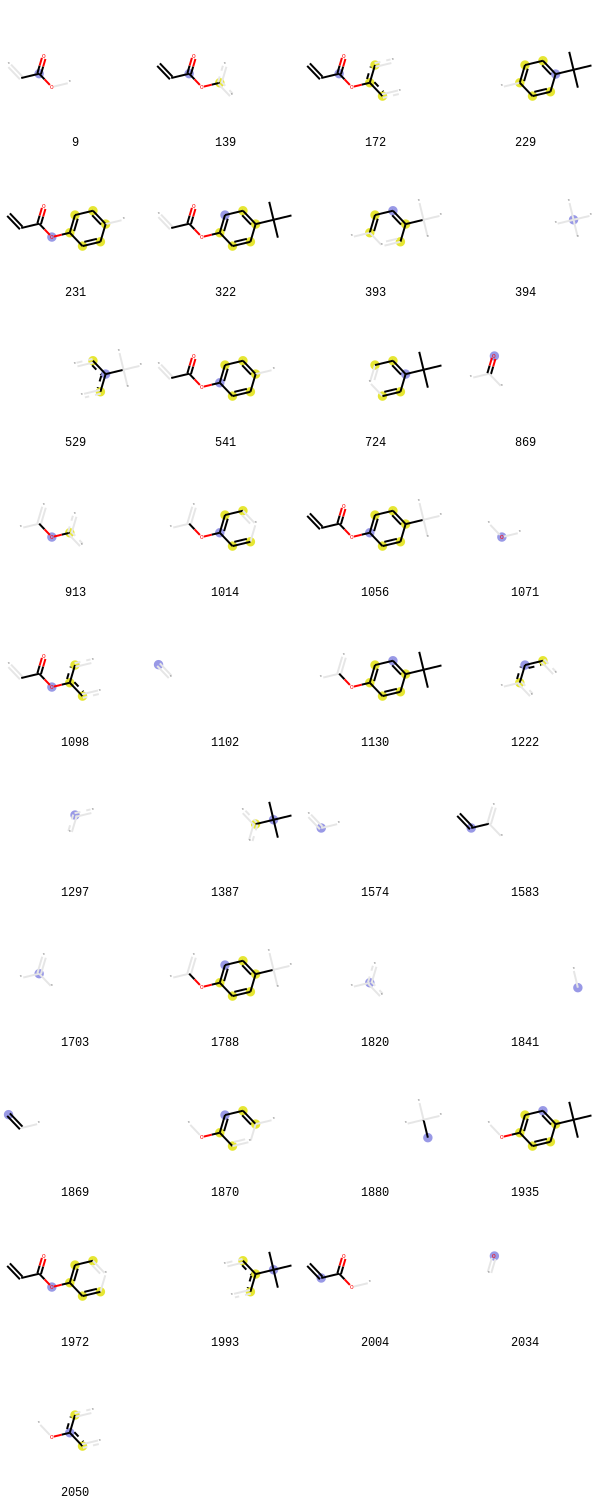

In [ ]:
prints=[(mol2,x,bi) for x in fp2.GetOnBits()]
prints


Draw.DrawMorganBits(prints,molsPerRow=4,legends=[str(x) for x in fp2.GetOnBits()])

In [ ]:
from ipywidgets import interact,fixed,IntSlider
def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))

In [ ]:
interact(renderFpBit, bitIdx=list(bi.keys()),mol=fixed(mol2),
         bitInfo=fixed(bi),fn=fixed(Draw.DrawMorganBit))

interactive(children=(Dropdown(description='bitIdx', options=(9, 139, 172, 229, 231, 322, 393, 394, 529, 541, …

<function __main__.renderFpBit>

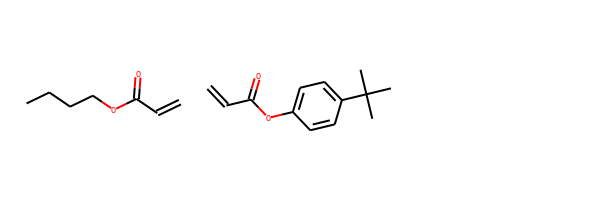

In [ ]:
Draw.MolsToGridImage([mol,mol2],4)

In [ ]:
fp2=AllChem.GetMorganFingerprintAsBitVect(mol2,4,2056,bitInfo=bi)
fp2_array=np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp2,fp2_array)
np.nonzero(fp2_array)
print(list(fp2.GetOnBits()))

[9, 139, 172, 229, 231, 322, 393, 394, 529, 541, 724, 869, 913, 1014, 1056, 1071, 1098, 1102, 1130, 1222, 1297, 1387, 1574, 1583, 1703, 1788, 1820, 1841, 1869, 1870, 1880, 1935, 1972, 1993, 2004, 2034, 2050]


In [ ]:
common=set(fp.GetOnBits()) & set(fp2.GetOnBits())
combined=set(fp.GetOnBits()) | set(fp2.GetOnBits())
print(list(fp.GetOnBits()))
print(list(fp2.GetOnBits()))
print(common)
print(combined)


[9, 75, 155, 343, 606, 752, 765, 869, 903, 941, 971, 1022, 1071, 1098, 1102, 1162, 1510, 1574, 1583, 1653, 1703, 1710, 1841, 1869, 2000, 2004, 2034]
[9, 139, 172, 229, 231, 322, 393, 394, 476, 529, 541, 724, 869, 913, 1014, 1056, 1071, 1098, 1102, 1130, 1222, 1297, 1387, 1574, 1583, 1703, 1788, 1820, 1841, 1869, 1870, 1880, 1935, 1972, 1993, 2004, 2034, 2050]
{869, 1574, 1703, 9, 1098, 1869, 1102, 1583, 1071, 1841, 2034, 2004}
{2050, 9, 529, 1297, 1820, 541, 1056, 1574, 1071, 1583, 1841, 322, 1098, 75, 1869, 1102, 1870, 343, 1880, 606, 869, 1130, 1387, 1653, 903, 393, 1162, 139, 394, 1935, 913, 155, 1703, 172, 941, 1710, 1972, 1222, 1993, 971, 2000, 2004, 724, 476, 229, 1510, 231, 752, 2034, 1014, 1788, 765, 1022}


In [ ]:
def cosine_simialrity(fp1,fp2):
  cosine_similarity=(fp1*fp2).sum()/(np.sqrt(fp1.sum())*np.sqrt(fp2.sum()))
  return cosine_similarity

cosine_simialrity(fp_array,fp2_array)


0.37463432463267765

In [ ]:
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(fp_array, fp2_array)/(norm(fp_array)*norm(fp2_array))

In [ ]:
cos_sim

0.37463432463267765

In [ ]:
fp2=AllChem.GetMorganFingerprintAsBitVect(mol2,5,1024,bitInfo=bi)
fp2_array=np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp2,fp2_array)
np.nonzero(fp2_array)
print(list(fp2.GetOnBits()))

In [ ]:
listt=[]
for i in range(df.shape[0]):
  mol=Chem.MolFromSmiles(df2.iloc[i,1])
  fp=AllChem.GetMorganFingerprintAsBitVect(mol2,1,40,bitInfo=bi)
  fp_array=np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp,fp_array)
  np.nonzero(fp2_array)
  listt.append(fp_array)


RDKit ERROR: [15:30:05] SMILES Parse Error: syntax error while parsing: O=
RDKit ERROR: [15:30:05] SMILES Parse Error: Failed parsing SMILES 'O=' for input: 'O='


In [ ]:
df3=pd.DataFrame(listt)
df4=pd.DataFrame(np.hstack((df.loc[:,"C_Atoms_Ring":].values,df3.values)))

In [ ]:
df4.shape

(277, 53)

In [ ]:
X=df4
Y=df["Tg"]

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
pd.DataFrame(X)

0         1         2    3         4   ...   48   49   50   51   52
0    2.382689 -1.208041 -0.170292  0.0  2.382689  ...  0.0  0.0  0.0  0.0  0.0
1   -0.782802  0.002185 -0.170292  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
2   -0.782802  0.002185 -0.170292  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
3    0.799943  0.002185 -0.170292  0.0  0.799943  ...  0.0  0.0  0.0  0.0  0.0
4    0.799943  0.002185 -0.170292  0.0  0.799943  ...  0.0  0.0  0.0  0.0  0.0
..        ...       ...       ...  ...       ...  ...  ...  ...  ...  ...  ...
272 -0.782802  1.514967 -0.170292  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
273 -0.782802  0.909854 -0.170292  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
274 -0.782802  0.304741 -0.885003  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
275 -0.782802 -0.300372 -0.885003  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0
276 -0.782802 -1.208041 -0.885003  0.0 -0.782802  ...  0.0  0.0  0.0  0.0  0.0

[277 rows x 53 columns]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1],activation="relu",kernel_regularizer="l2"))
model.add(Dense(10,activation="relu",kernel_regularizer="l2"))
model.add(Dense(30,activation="relu",kernel_regularizer="l2"))
model.add(Dense(1))
optimizer=optimizers.adam(lr=0.05)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=100,batch_size=128,validation_split=0.1) 

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 30)                1620      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_39 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 31        
Total params: 2,291
Trainable params: 2,291
Non-trainable params: 0
_________________________________________________________________
